# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import metrics
import quality
import profiling

# Load correlation matrix

In [2]:
CORR_MATRIX = "data/correlation_matrix.csv"

In [3]:
X, Y = profiling.load_correlation_matrix(CORR_MATRIX)

# MOA matching

In [4]:
Y.groupby("Metadata_moa.x")["Var1"].count()

Metadata_moa.x
Apoptosis                                  5
Autophagy                                  4
BMP                                        5
Cell Cycle                                 7
Chromatin Modifiers                        1
Circadian Rhythm                           6
Cytoskeletal Re-org                        5
DNA Damage                                 3
ER Stress/UPR                             12
Hedgehog                                   3
Hippo                                      7
Hypoxia                                   10
Insulin Receptor Signaling                 4
JAK/STAT                                   3
MAPK                                      28
Mitochondria Oxidative Phosphorylation     3
NFkB                                      18
NOTCH                                      8
PI3K/AKT                                  13
PKA                                        9
PKC                                        3
RTK                                     

In [5]:
moa_matches = []
for k,r in Y.iterrows():
    m = Y["Metadata_moa.x"] == r["Metadata_moa.x"]
    moa_matches.append(m)

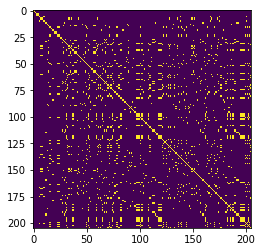

In [6]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [7]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = quality.enrichment_analysis_matrix(Z[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

R = pd.DataFrame(data=results)

98.0 0.8270350469585922
[[   28   391]
 [ 1136 19355]] 20910
98.2 0.8315299585766087
[[   23   354]
 [ 1141 19392]] 20910
98.4 0.8373264767338333
[[   21   314]
 [ 1143 19432]] 20910
98.60000000000001 0.8420264045677555
[[   18   275]
 [ 1146 19471]] 20910
98.80000000000001 0.8478558386606143
[[   17   234]
 [ 1147 19512]] 20910
99.00000000000001 0.8555675370526752
[[   13   197]
 [ 1151 19549]] 20910
99.20000000000002 0.8619294434880579
[[   11   157]
 [ 1153 19589]] 20910
99.40000000000002 0.8713616386806315
[[    9   117]
 [ 1155 19629]] 20910
99.60000000000002 0.8845252868026803
[[    5    79]
 [ 1159 19667]] 20910


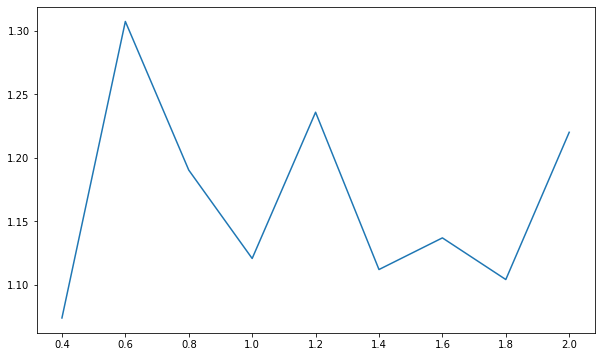

In [8]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])

# Average precision analysis

In [9]:
def average_precision(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        ap = metrics.average_precision(moa_matches[i, rank[1:rank_pos]])
        results.append(ap)
    return results

In [10]:
positions = [x for x in range(5,55,5)]
CRM = np.asarray(X[Y.Var1])
map_at = [np.mean( average_precision(CRM, moa_matches, pos) ) for pos in positions]

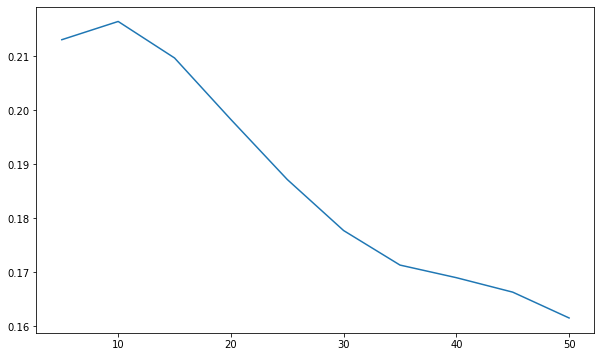

In [11]:
plt.figure(figsize=(10,6))
plt.plot(positions, map_at)

In [12]:
np.mean( average_precision(CRM, moa_matches) )

0.11220953646657301

# Recall analysis

In [13]:
def recall_at(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        rc = np.sum(moa_matches[i, rank[1:rank_pos]]) / np.sum(moa_matches[i,:])
        results.append(rc)
    return results

In [14]:
recall = [np.mean( recall_at(CRM, moa_matches, pos) ) for pos in positions]

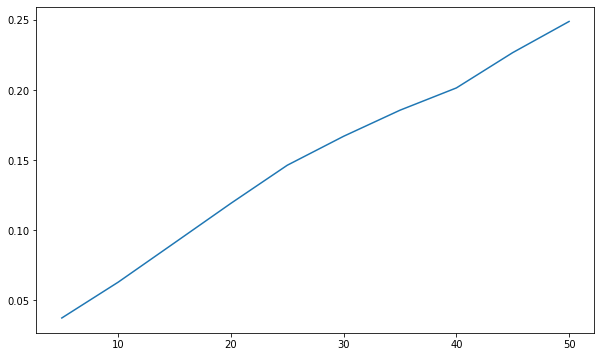

In [15]:
plt.figure(figsize=(10,6))
plt.plot(positions, recall)

In [16]:
np.mean( recall_at(CRM, moa_matches, 50) )

0.24887382621657334